In [1]:
import os
import openai

import pickle
import pandas as pd
from tqdm import tqdm

In [ ]:
org = None #organization ID
org_api_key = None # api key

openai.organization = org
openai.api_key = org_api_key

## Fine-tune GPT-3

### Prepare data

In [2]:
!yes | openai tools fine_tunes.prepare_data -f 'gpt3_train/train_data_samples.jsonl'

Analyzing...

- Your file contains 4961 prompt-completion pairs
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- Your data does not contain a common ending at the end of your completions. Having a common ending string appended to the end of the completion makes it clearer to the fine-tuned model where the completion should end. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples.
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for

In [3]:
!cat 'gpt3_train/train_data_samples_prepared.jsonl' | wc -l

4961


### Upload file

In [3]:
file = openai.File.create(
  file=open("gpt3_train/train_data_samples_prepared.jsonl"),
  purpose='fine-tune'
)

In [ ]:
print(file.id)

### Fine tune

In [12]:
ft_result = openai.FineTune.create(training_file=file.id,
                      model = 'ada',
                      n_epochs=4,
                      suffix='minus_coref')

In [ ]:
print(ft_result.id)

In [21]:
ft_model = openai.FineTune.retrieve(id=ft_result.id)

In [22]:
ft_model.status

'succeeded'

### Get similar sentences of test samples

In [ ]:
# model name
print(ft_model.fine_tuned_model)

In [41]:
# read test data (topic sentences)
df = pd.read_json('gpt3_train/test_data_samples.jsonl', lines = True)
df = df.rename(columns = {'text':'coref_text'})
# read test data (noise sentences)
noise = pd.read_json('gpt3_train/test_data_noise.jsonl', lines = True)
noise = noise.rename(columns = {'text':'coref_text'})

In [27]:
noise.shape

(4938, 5)

In [28]:
df.shape

(2910, 5)

In [44]:
# Higher values means the model will take more risks. 
#Try 0.9 for more creative applications, and 0 (argmax sampling) 
#for ones with a well-defined answer.
temp = 0.5

# Number between -2.0 and 2.0. Positive values penalize new tokens based on their 
#existing frequency in the text so far, decreasing the model's likelihood to 
#repeat the same line verbatim.
fp=0.2

# Number between -2.0 and 2.0. Positive values penalize new tokens based on whether 
#they appear in the text so far, increasing the model's 
#likelihood to talk about new topics.
pp=0.2

In [29]:
df.columns

Index(['sentence_id', 'true_text', 'coref_text', 'dist', 'true_labels'], dtype='object')

In [11]:
def create_completions(t, fname):
    for col in ['coref_text', 'true_text']:
        gpt_samples = {}
        for s in tqdm(t[col].tolist()):
            response = openai.Completion.create(
                  model=ft_model.fine_tuned_model, # fine-tuned model
                  prompt="{} ->".format(s),
                  temperature=temp,
                  max_tokens=60,
                  top_p=1.0,
                  n = 5, # 5 completions
                  frequency_penalty=fp,
                  presence_penalty=pp,
                  stop=["\n"]
                )

            gpt_samples[s] = [choice['text'] for choice in response.choices]
            pickle.dump(gpt_samples, 
                open('gpt3_train/{}_{}_{}_{}_{}.pk'.\
                     format(fname, col, temp, fp, pp), 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████████| 4938/4938 [39:34<00:00,  2.08it/s]


In [ ]:
create_completions(df, 'ada_minus-coref-2022')
create_completions(noise, 'ada_minus-coref-2022_noise')

### Delete file 

In [ ]:
# openai.File.delete(file.id)
# openai.Model.delete(ft_model.fine_tuned_model)

## Evaluate GPT results

### Merge samples with original text

In [32]:
def merge_with_gpt_samples(gpt_samples, df, merge_cols):
    gpt_samples = pd.DataFrame(gpt_samples)
    gpt_samples = gpt_samples.T.reset_index()
    gpt_samples.columns = ['text'] + [i for i in range(0, (len(gpt_samples.columns)-1))]
    
    rows = df.shape[0]
    df = pd.merge(df, gpt_samples, left_on=merge_cols, right_on='text')
    df = df.drop(columns='text').reset_index(drop = True)
    
    # assert df.shape[0] == rows, 'Sample and original dataframe should be 1:1 match'
    
    df = pd.melt(df.drop(columns=['dist', 'embeddings'], errors='ignore'), 
             id_vars = ['sentence_id','true_text', 'true_labels', 'coref_text']).\
        drop(columns='variable')
    df = df[df[merge_cols] != df.value]
    
    df = df.groupby(['true_labels', 'value']).head(1)
    df = df.reset_index(drop = True)
    
    return(df)

In [42]:
df = pd.read_json('gpt3_train/test_data_samples.jsonl', lines = True)
df = df.rename(columns = {'text':'coref_text'})

noise = pd.read_json('gpt3_train/test_data_noise.jsonl', lines = True)
noise = noise.rename(columns = {'text':'coref_text'})

In [45]:
gpt_samples = pickle.load(open('gpt3_train/ada_minus-coref-2022_true_text_{}_{}_{}.pkl'.\
                 format(temp, fp, pp), 'rb'))
df_true = merge_with_gpt_samples(gpt_samples, df, merge_cols='true_text')

In [46]:
gpt_samples = pickle.load(open('gpt3_train/ada_minus-coref-2022_coref_text_{}_{}_{}.pkl'.\
                 format(temp, fp, pp), 'rb'))
df_coref = merge_with_gpt_samples(gpt_samples, df, merge_cols='coref_text')

In [47]:
gpt_samples = pickle.load(open('gpt3_train/ada_minus-coref-2022_noise_true_text_{}_{}_{}.pkl'.\
                 format(temp, fp, pp), 'rb'))
noise_true = merge_with_gpt_samples(gpt_samples, noise, merge_cols='true_text')

In [48]:
gpt_samples = pickle.load(open('gpt3_train/ada_minus-coref-2022_noise_coref_text_{}_{}_{}.pkl'.\
                 format(temp, fp, pp), 'rb'))
noise_coref = merge_with_gpt_samples(gpt_samples, noise, merge_cols='coref_text')

### Validate GPT-3 results

In [70]:
from sentence_transformers import SentenceTransformer, util
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [166]:
import copy
import torch
import numpy as np

# check_items: dictionary key:(text, true label), value: [gpt3 generated text]
def create_matching_pairs(check_items):
    updated_items = []
    for key, vals in tqdm(check_items.items()):
        # assign factiva text, and true label
        ref_text, label = key
        
        # get embedding of test data
        embeddings = []
        embeddings.append(embedder.encode(ref_text, convert_to_tensor=False))

        # get embedding of gpt-3 generated similar data
        for val in vals:
            embeddings.append(embedder.encode(val, convert_to_tensor=False))

        # embeddings = np.reshape(embeddings, (len(embeddings), 384))
        # embeddings = torch.tensor(embeddings).cuda()

        # calculate cosine similarity
        cosine_scores = util.cos_sim(embeddings, embeddings)

        # compare cosine scores
        for i in range(0,1): #use only first row, original text
            for j in range(i+1, len(cosine_scores)):
                if i == 0:
                    updated_items.append({
                    'text': ref_text,
                    'label': label,
                    'val1': vals[j-1],
                    'val2': None,    
                    'score':cosine_scores[i][j].item()
                })
                else:
                    updated_items.append({
                    'text': ref_text,
                    'label': label,
                    'val1': vals[i-1],
                    'val2': vals[j-1],    
                    'score':cosine_scores[i][j].item()
                })
                    
    check_items = pd.DataFrame(updated_items)
    check_items = check_items.sort_values('score', ascending = False)
    check_items = check_items[(check_items.score >= 0.75) & (check_items.score < 0.99)]
    
    check_items = pd.melt(check_items.drop(columns='score'), id_vars=['text', 'label'])
    check_items = check_items[~check_items.value.isnull()].drop(columns='variable')

    check_items = check_items.rename(columns={'label':'true_labels'})
    check_items = check_items.drop_duplicates().reset_index(drop = True)
    return check_items

In [169]:
def get_clean_data(df, col):
    check_items = df.groupby([col, 'true_labels'])['value'].apply(list).to_dict()
    check_items = create_matching_pairs(check_items)

    df = df.drop(columns=['value']).drop_duplicates().reset_index(drop = True)
    df = pd.merge(df, check_items, 
                  left_on=['true_labels', col],
                  right_on=['true_labels', 'text'])

    df = df.drop(columns='text').\
        rename(columns = {'value': 'text'}).\
        reset_index(drop = True)
    
    return(df)

In [170]:
df = df_true.copy()
df = get_clean_data(df, col = 'true_text')

df.to_json('gpt3_train/synthetic_clusters_true_text.jsonl', 
           lines = True, orient='records')

100%|█████████████████████████████████████████████████| 2891/2891 [03:20<00:00, 14.44it/s]


In [173]:
df = df_coref.copy()
df = get_clean_data(df, col = 'coref_text')

df.to_json('gpt3_train/synthetic_clusters_coref_text.jsonl', 
           lines = True, orient='records')

100%|█████████████████████████████████████████████████| 2908/2908 [04:43<00:00, 10.25it/s]


In [176]:
df = noise_true.copy()
df = get_clean_data(df, col = 'true_text')

df.to_json('gpt3_train/synthetic_clusters_noise_true_text.jsonl', 
           lines = True, orient='records')

100%|█████████████████████████████████████████████████| 4931/4931 [04:52<00:00, 16.86it/s]


In [178]:
df = noise_coref.copy()
df = get_clean_data(df, col = 'coref_text')

df.to_json('gpt3_train/synthetic_clusters_noise_coref_text.jsonl', 
           lines = True, orient='records')

100%|█████████████████████████████████████████████████| 4938/4938 [04:24<00:00, 18.69it/s]


### Plot synthetic data generated

In [188]:
from sentence_transformers import SentenceTransformer
import sys 
sys.path.append('../')
from fast_tsne.fast_tsne import fast_tsne
import matplotlib.pyplot as plt

In [179]:
df = pd.read_json('gpt3_train/synthetic_clusters_coref_text.jsonl', lines = True)
noise = pd.read_json('gpt3_train/synthetic_clusters_noise_coref_text.jsonl', lines = True)

In [185]:
df = pd.concat([df, noise], axis = 0).reset_index(drop = True)

In [186]:
df.true_labels.unique()

array([18, 24, 63,  1])

In [189]:
# Get sentence embedding
def get_embeddings(data, model_name='all-MiniLM-L6-v2', device='cpu', convert=True):
    print('Getting embeddings ...')
    smodel = SentenceTransformer(model_name, device=device)
    embeddings = smodel.encode(data, batch_size=64, show_progress_bar=True, convert_to_tensor=False)
    return (embeddings)

In [190]:
embeddings = get_embeddings(df.text.tolist())

Getting embeddings ...


Batches:   0%|          | 0/190 [00:00<?, ?it/s]

In [191]:
# embeddings1 = pd.DataFrame({'embeddings':list(embeddings)})
df['embeddings'] = list(embeddings)

In [192]:
%time Z1 = fast_tsne(df.embeddings.tolist())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
=============== t-SNE v1.2.1 ===============
fast_tsne data_path: data_2022-10-14 05:05:03.303810-325608918.dat
fast_tsne result_path: result_2022-10-14 05:05:03.303810-325608918.dat
fast_tsne nthreads: 8
Read the following parameters:
	 n 12110 by d 384 dataset, theta 0.500000,
	 perplexity 30.000000, no_dims 2, max_iter 750,
	 stop_lying_iter 250, mom_switch_iter 250,
	 momentum 0.500000, final_momentum 0.800000,
	 learning_rate 1009.166667, max_step_norm 5.000000,
	 K -1, sigma -1.000000, nbody_algo 2,
	 knn_algo 1, early_exag_coeff 12.000000,
	 no_momentum_during_exag 0, n_trees 50, search_k 4500,
	 start_late_exag_iter -1, late_exag_coeff -1.000000
	 nterms 3, in

In [193]:
col = {'18':'#abd9e9',
'24':'#fdae61',
'63': '#D2AB3C',
'1': '#808080'}

true_labels = {18:'Kevin rudd',
24:'Climate change',
63:'Indeginous people',
1: 'Noise'}

In [194]:
Z1 = pd.DataFrame({'x': Z1[:,0], 'y':Z1[:,1], 'label':df.true_labels.tolist()})

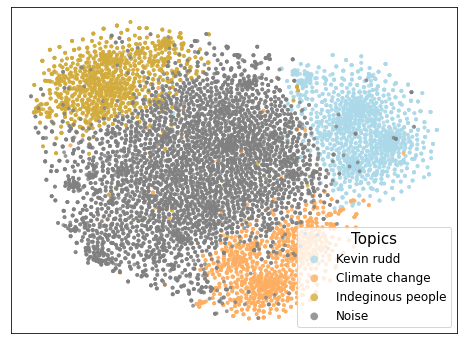

In [196]:
fig, ax = plt.subplots(figsize=(8,6))
for label in Z1.label.unique():
    ax.scatter(Z1[Z1.label == label].x.tolist(), 
               Z1[Z1.label == label].y.tolist(), 
               c=[col[str(i)] for i in Z1[Z1.label == label].label.tolist()], 
               s=15, label=true_labels[label],
               alpha=0.8, edgecolors='none')

ax.legend(title='Topics', loc=4, prop={'size': 12}, 
          title_fontsize=15, markerscale=2)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()
fig.savefig('pics/synthetic_clusters_coref_text.png', bbox_inches='tight')